In [1]:
import numpy as np
import pandas as pd
import os
import json
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import lightgbm as lgb
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

BASE_PATH = "/kaggle/input/petfinder-adoption-prediction"
TRAIN_CSV = os.path.join(BASE_PATH, "train", "train.csv")
TEST_CSV  = os.path.join(BASE_PATH, "test", "test.csv")

In [2]:
def plot_target_distribution(df):
    plt.figure(figsize=(8, 5))
    
    temp_df = df.copy()
    temp_df['AdoptionSpeed_Cat'] = temp_df['AdoptionSpeed'].astype(int).astype(str)
    order = ['0', '1', '2', '3', '4']
    
    ax = sns.countplot(x='AdoptionSpeed_Cat', data=temp_df, 
                       order=order, palette='viridis', 
                       hue='AdoptionSpeed_Cat', dodge=False)
    
    plt.title('Distribution of Adoption Speed (Target)', fontsize=15, fontweight='bold')
    plt.xlabel('Adoption Speed Class', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    
    if ax.get_legend() is not None:
        ax.get_legend().remove()
    
    for p in ax.patches:
        height = p.get_height()
        if np.isfinite(height):
            ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='center', xytext=(0, 5), textcoords='offset points')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", cbar=False,
                xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
    plt.title(f'{title} (Normalized)', fontsize=15, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_model_comparison(scores_dict):

    models = list(scores_dict.keys())
    scores = list(scores_dict.values())
    
    plt.figure(figsize=(8, 5))
    colors = ['grey' if 'Ensemble' not in m else 'crimson' for m in models]
    
    ax = sns.barplot(x=models, y=scores, palette=colors, hue=models, dodge=False)
    
    plt.ylim(min(scores) - 0.05, max(scores) + 0.02)
    plt.title('Model Performance Comparison (QWK Score)', fontsize=15, fontweight='bold')
    plt.ylabel('Quadratic Weighted Kappa')
    
    if ax.get_legend() is not None:
        ax.get_legend().remove()
    
    for p in ax.patches:
        height = p.get_height()
        if np.isfinite(height):
            ax.annotate(f'{height:.4f}', (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontweight='bold')
    plt.show()


In [3]:
def optimized_kappa(y_true, y_pred):

    def func(x):
        if x[0] < x[1] < x[2] < x[3]:
            labels = pd.cut(y_pred, [-np.inf] + list(x) + [np.inf], labels=[0, 1, 2, 3, 4])
            return -cohen_kappa_score(y_true, labels, weights='quadratic')
        return 100

    init_x = [1.5, 2.0, 2.5, 3.0]
    res = optimize.minimize(func, init_x, method='Nelder-Mead', tol=1e-5)
    return res.x

def apply_thr(y_pred, thr):
 
    return pd.cut(y_pred, [-np.inf] + list(thr) + [np.inf], labels=[0, 1, 2, 3, 4]).astype(int)

In [4]:
def extract_metadata(df, mode):

    sent_scores, sent_mags, meta_scores, meta_colors = [], [], [], []
    print(f"Extracting metadata for {mode}...")
    
    for pet_id in df['PetID']:
        s_score = s_mag = m_score = m_color = 0.0
        try:
            with open(os.path.join(BASE_PATH, f"{mode}_sentiment", f"{pet_id}.json"), "r") as f:
                j = json.load(f)
                s_score = j.get("documentSentiment", {}).get("score", 0.0)
                s_mag = j.get("documentSentiment", {}).get("magnitude", 0.0)
        except: pass
        
        try:
            with open(os.path.join(BASE_PATH, f"{mode}_metadata", f"{pet_id}-1.json"), "r") as f:
                j = json.load(f)
                labels = j.get("labelAnnotations", [])
                if labels: m_score = np.mean([l.get("score", 0.0) for l in labels[:3]])
                colors = j.get("imagePropertiesAnnotation", {}).get("dominantColors", {}).get("colors", [])
                if colors: m_color = colors[0].get("score", 0.0)
        except: pass
        
        sent_scores.append(s_score)
        sent_mags.append(s_mag)
        meta_scores.append(m_score)
        meta_colors.append(m_color)
        
    df['Sent_Score'] = sent_scores
    df['Sent_Mag'] = sent_mags
    df['Img_Label_Score'] = meta_scores
    df['Img_Color_Score'] = meta_colors
    return df

def feature_engineering(train, test):

    print("Engineering features...")
    
    # 1. TEXT (TF-IDF + SVD)
    all_text = pd.concat([train['Description'], test['Description']]).fillna("none")
    tfidf = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1, 2))
    svd = TruncatedSVD(n_components=12, random_state=42)
    
    text_features = svd.fit_transform(tfidf.fit_transform(all_text))
    text_df = pd.DataFrame(text_features, columns=[f'svd_{i}' for i in range(12)])
    

    train_text = text_df.iloc[:len(train)].reset_index(drop=True)
    test_text  = text_df.iloc[len(train):].reset_index(drop=True)
    
    train = pd.concat([train, train_text], axis=1)
    test  = pd.concat([test, test_text], axis=1)


    full = pd.concat([train, test], sort=False).reset_index(drop=True)
    

    full['RescuerID_Int'] = pd.factorize(full['RescuerID'])[0]
    

    full['Rescuer_Count'] = full.groupby('RescuerID')['PetID'].transform('count')
    

    full['Breed_Fee_Mean'] = full.groupby('Breed1')['Fee'].transform('mean')
    full['Fee_Diff_Breed'] = full['Fee'] - full['Breed_Fee_Mean']
    
    train = full.iloc[:len(train)].reset_index(drop=True)
    test  = full.iloc[len(train):].reset_index(drop=True)
    

    for df in [train, test]:
        df['Desc_Len'] = df['Description'].fillna("").apply(len)
        df['Name_Len'] = df['Name'].fillna("").apply(len)
        df['Photo_Per_Pet'] = df['PhotoAmt'] / df['Quantity'].replace(0, 1)
        df['Is_Free'] = (df['Fee'] == 0).astype(int)
        
    return train, test

Loading data...
[INFO] Target Distribution:


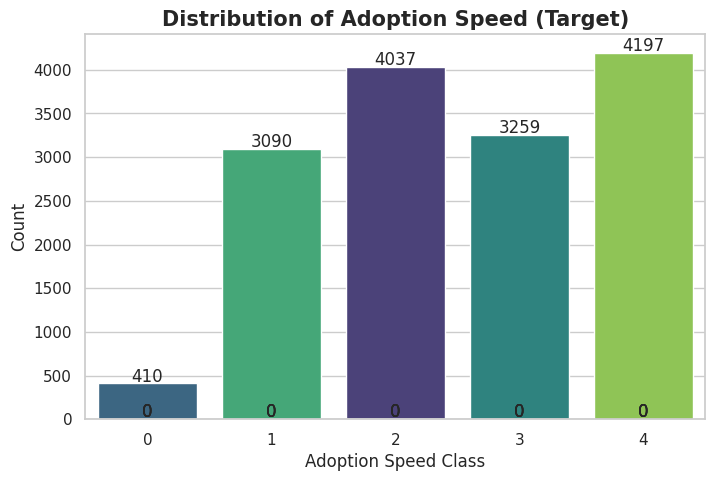

Extracting metadata for train...
Extracting metadata for test...
Engineering features...


In [5]:
# Load Data
print("Loading data...")
train = pd.read_csv(TRAIN_CSV)
test = pd.read_csv(TEST_CSV)

print("Target Distribution:")
plot_target_distribution(train)

train = extract_metadata(train, "train")
test = extract_metadata(test, "test")
train, test = feature_engineering(train, test)

y = train['AdoptionSpeed']
groups = train['RescuerID']

drop_cols = ['Name', 'RescuerID', 'Description', 'PetID', 'AdoptionSpeed']
X = train.drop(columns=[c for c in drop_cols if c in train.columns])
X_test = test.drop(columns=[c for c in drop_cols if c in test.columns])

X_test = X_test[X.columns]

cat_features = ['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3', 
                'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 
                'Health', 'State', 'RescuerID_Int']

for c in cat_features:
    X[c] = X[c].fillna(-1).astype(int)
    X_test[c] = X_test[c].fillna(-1).astype(int)


cat_indices = [X.columns.get_loc(c) for c in cat_features if c in X.columns]

In [7]:
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

oof_lgb = np.zeros(len(X))
oof_cat = np.zeros(len(X))
oof_xgb = np.zeros(len(X))
test_ens = np.zeros(len(X_test))

scores_lgb, scores_cat, scores_xgb = [], [], []
final_lgb_model = None 

print("--- Starting 3-Model Ensemble Training ---")

for fold, (trn_idx, val_idx) in enumerate(gkf.split(X, y, groups=groups)):
    X_tr, X_val = X.iloc[trn_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[trn_idx], y.iloc[val_idx]
    
    # ---------------- LIGHTGBM ----------------
    lgb_params = {
        'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.01,
        'num_leaves': 60, 'max_depth': 9, 'bagging_fraction': 0.8,
        'feature_fraction': 0.6, 'lambda_l2': 2.0, 'verbosity': -1, 'seed': 42, 'device': 'gpu'
    }
    d_train = lgb.Dataset(X_tr, y_tr)
    d_val = lgb.Dataset(X_val, y_val, reference=d_train)
    
    m_lgb = lgb.train(lgb_params, d_train, num_boost_round=3000, 
                      valid_sets=[d_val], callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)])
    
    val_pred = m_lgb.predict(X_val, num_iteration=m_lgb.best_iteration)
    oof_lgb[val_idx] = val_pred
    
    # Store score and model
    thr = optimized_kappa(y_val, val_pred)
    scores_lgb.append(cohen_kappa_score(y_val, apply_thr(val_pred, thr), weights='quadratic'))
    if fold == 0: final_lgb_model = m_lgb 
    
    # ---------------- CATBOOST ----------------
    m_cat = CatBoostRegressor(iterations=3000, learning_rate=0.01, depth=6, 
                              eval_metric='RMSE', random_seed=42, verbose=0,
                              allow_writing_files=False, cat_features=cat_indices,
                              task_type="GPU",devices='0')
    m_cat.fit(X_tr, y_tr, eval_set=(X_val, y_val), early_stopping_rounds=100)
    
    val_pred = m_cat.predict(X_val)
    oof_cat[val_idx] = val_pred
    
    thr = optimized_kappa(y_val, val_pred)
    scores_cat.append(cohen_kappa_score(y_val, apply_thr(val_pred, thr), weights='quadratic'))
    
    # ---------------- XGBOOST ----------------
    m_xgb = XGBRegressor(n_estimators=3000, learning_rate=0.01, max_depth=7,
                         subsample=0.7, colsample_bytree=0.7, random_state=42,
                         n_jobs=-1, tree_method='gpu_hist', enable_categorical=True)
    m_xgb.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=100, verbose=False)
    
    val_pred = m_xgb.predict(X_val)
    oof_xgb[val_idx] = val_pred
    
    thr = optimized_kappa(y_val, val_pred)
    scores_xgb.append(cohen_kappa_score(y_val, apply_thr(val_pred, thr), weights='quadratic'))
    
    # Add to Test Predictions (Weighted Average)
    w_lgb, w_cat, w_xgb = 0.30, 0.40, 0.30
    fold_test_pred = (w_lgb * m_lgb.predict(X_test, num_iteration=m_lgb.best_iteration) +
                      w_cat * m_cat.predict(X_test) +
                      w_xgb * m_xgb.predict(X_test))
    test_ens += fold_test_pred / n_splits
    
    print(f"Fold {fold+1} complete.")

--- Starting 3-Model Ensemble Training ---


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[860]	valid_0's rmse: 1.0744


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:09:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:09:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarn

Fold 1 complete.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[696]	valid_0's rmse: 1.10119


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:10:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:10:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Fold 2 complete.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[485]	valid_0's rmse: 1.05726


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:12:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:12:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Fold 3 complete.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[622]	valid_0's rmse: 1.03157


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:13:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:14:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Fold 4 complete.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[517]	valid_0's rmse: 1.08098


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:15:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:15:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Fold 5 complete.



Final Ensemble CV QWK: 0.4112


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


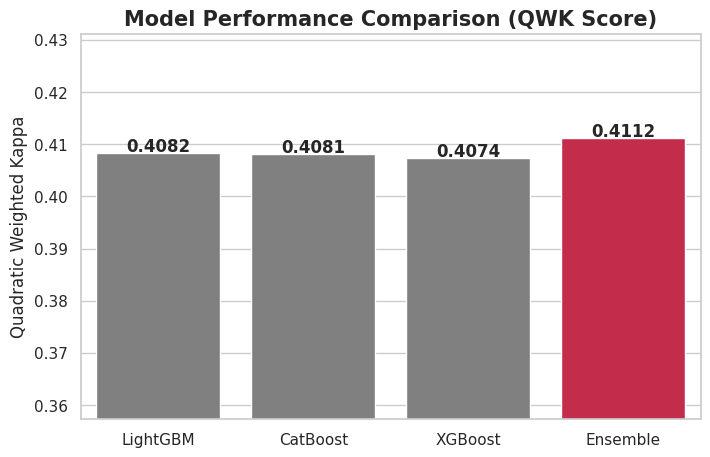

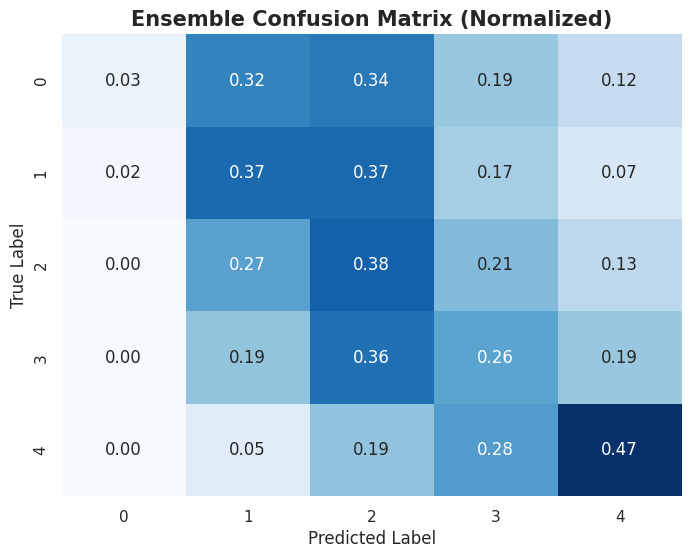

Saved submission.csv


In [8]:
# Blend OOF predictions
w_lgb, w_cat, w_xgb = 0.30, 0.40, 0.30
oof_ens = w_lgb*oof_lgb + w_cat*oof_cat + w_xgb*oof_xgb

# Optimize Thresholds on Ensemble
best_thr = optimized_kappa(y, oof_ens)
final_preds_cat = apply_thr(oof_ens, best_thr)
final_score = cohen_kappa_score(y, final_preds_cat, weights='quadratic')

print(f"\nFinal Ensemble CV QWK: {final_score:.4f}")

# --- REPORTING ---
# 1. Comparison Plot
model_scores = {
    'LightGBM': np.mean(scores_lgb),
    'CatBoost': np.mean(scores_cat),
    'XGBoost':  np.mean(scores_xgb),
    'Ensemble': final_score
}
plot_model_comparison(model_scores)

# 2. Confusion Matrix

plot_confusion_matrix(y, final_preds_cat, title="Ensemble Confusion Matrix")

# 3. Save Submission
sub = pd.DataFrame({'PetID': test['PetID'], 'AdoptionSpeed': apply_thr(test_ens, best_thr)})
sub.to_csv('submission.csv', index=False)
print("Saved submission.csv")